# Imports de librairies

In [71]:
import glob
import itertools
import os
import pathlib
import pickle
import yaml


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 

In [69]:
!pip3 freeze > requirements.txt

# configuration des paramètres avec le fichier yaml 

In [74]:
with open('../parameters.yaml') as yaml_data:
    
    parameters = yaml.safe_load(yaml_data)

TRAINING_CSV_PATH = parameters[0]['TRAINING_CSV_PATH']
TEST_CSV_PATH = parameters[1]['TEST_CSV_PATH']
IMAGE_WIDTH = parameters[2]['IMAGE_WIDTH']
IMAGE_HEIGHT = parameters[3]['IMAGE_HEIGHT']
SEED = parameters[4]['SEED']
TEST_IMAGES_PATH = parameters[5]['TEST_IMAGES_PATH']

# Importation des bases

## Création de la base d'entrainement 

In [73]:
os.path.dirname(TRAINING_CSV_PATH)

'../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

In [8]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [9]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
39204,00007_00025.ppm,52,56,5,6,47,51,42,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
39205,00007_00026.ppm,56,58,5,5,51,53,42,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
39206,00007_00027.ppm,58,62,5,6,53,57,42,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
39207,00007_00028.ppm,63,69,5,7,58,63,42,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
39208,00007_00029.ppm,68,69,7,6,62,63,42,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [10]:
images_df.shape

(39209, 9)

## Création de la table Data Final test pour l'évaluation du modèle

In [76]:
test_images_df = pd.read_csv(TEST_CSV_PATH, sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: TEST_IMAGES_PATH + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,../data/raw/GTSRB/Final_Test/Images/12625.ppm
12626,12626.ppm,50,51,6,5,45,46,33,../data/raw/GTSRB/Final_Test/Images/12626.ppm
12627,12627.ppm,29,29,6,6,24,24,6,../data/raw/GTSRB/Final_Test/Images/12627.ppm
12628,12628.ppm,48,49,5,6,43,44,7,../data/raw/GTSRB/Final_Test/Images/12628.ppm
12629,12629.ppm,32,31,6,5,27,26,10,../data/raw/GTSRB/Final_Test/Images/12629.ppm


In [54]:
test_list = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)


In [55]:
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


# Lecture d'images

In [ ]:
# Reading only 200 images for the moment
images_list = build_images_list(images_df.head(200)['path'].values,
                                images_df.head(200).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)

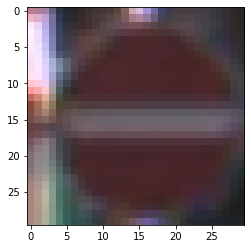

In [ ]:
plt.imshow(images_list[90])

In [ ]:
build_classes_array(images_df)

array([17, 17, 17, ..., 11, 11, 11])

In [ ]:
images_df['ClassId'].value_counts()

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
6      420
16     420
22     390
36     390
40     360
20     360
21     330
39     300
24     270
29     270
32     240
42     240
41     240
27     240
37     210
19     210
0      210
Name: ClassId, dtype: int64

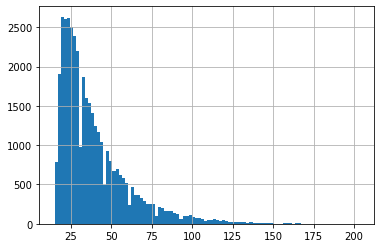

In [ ]:
(images_df['Roi.X2'] - images_df['Roi.X1']).hist(bins=100);

In [ ]:
(images_df['Roi.Y2'] - images_df['Roi.Y1']).median()

32.0

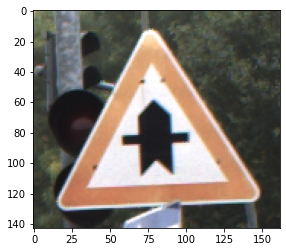

In [11]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]))

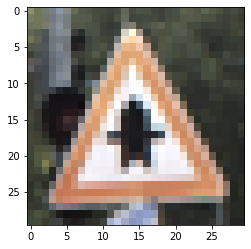

In [12]:
#modifie la taille de l'image 
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))

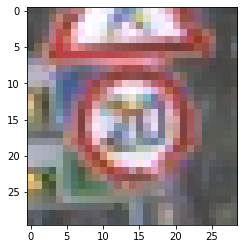

In [13]:
#affichage avec Jupyter 
img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00000/00000_00000.ppm')
plt.imshow(img)

In [ ]:
images_df.head(1)

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,28,33,6,6,23,28,17,./GTSRB/Final_Training/Images/00017/00000_0000...


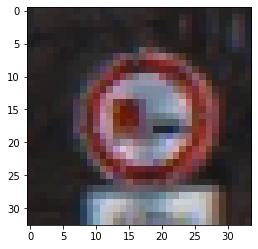

In [14]:
img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00010/00029_00010.ppm')
plt.imshow(img)

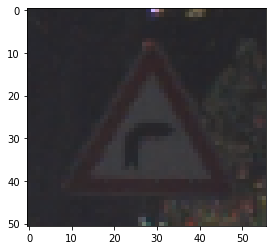

In [15]:
#affichage du panneau de la classe 20 
plt.imshow(Image.open(images_df.query('ClassId == 20').iloc[20]['path']))

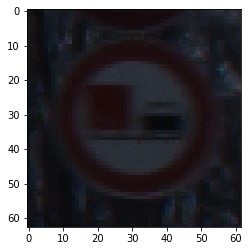

In [ ]:
#Lecture pour colab
img = Image.open('./GTSRB/Final_Training/Images/00010/00005_00029.ppm')
plt.imshow(img)

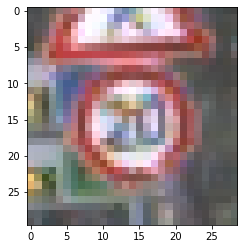

In [ ]:
#pour colab
img = Image.open('./GTSRB/Final_Training/Images/00000/00000_00000.ppm')
plt.imshow(img)

# 1) Neural Network 

## Modèle sur l'échantillon total

### Création du test and train set

In [16]:
images_df.shape

(39209, 9)

In [ ]:
N = 10_000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [ ]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
print(y_train.shape, y_test.shape)

(31367, 43) (7842, 43)


### Creation et entrainement du modèle 

In [ ]:
# TPU pour acceler la vitesse de calcul : UNIQUEMENT SUR COLLAB 
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.79.74.202:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.79.74.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.74.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
#MODEL AVEC TPU 
with tpu_strategy.scope():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

In [ ]:
#MODEL SANS TPU : SUR JUPYTER 
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367, 43) (7842, 43)


Entrainement du modele :

In [ ]:
%%time
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
981/981 [==============================] - 29s 24ms/step - loss: 2.9045 - accuracy: 0.4203 - val_loss: 0.4505 - val_accuracy: 0.8984
Epoch 2/15
981/981 [==============================] - 20s 21ms/step - loss: 0.6517 - accuracy: 0.8206 - val_loss: 0.1800 - val_accuracy: 0.9584
Epoch 3/15
981/981 [==============================] - 21s 21ms/step - loss: 0.3841 - accuracy: 0.8921 - val_loss: 0.1474 - val_accuracy: 0.9639
Epoch 4/15
981/981 [==============================] - 21s 21ms/step - loss: 0.2931 - accuracy: 0.9204 - val_loss: 0.0752 - val_accuracy: 0.9821
Epoch 5/15
981/981 [==============================] - 20s 21ms/step - loss: 0.2651 - accuracy: 0.9301 - val_loss: 0.0515 - val_accuracy: 0.9871
Epoch 6/15
981/981 [==============================] - 21s 21ms/step - loss: 0.1757 - accuracy: 0.9530 - val_loss: 0.1685 - val_accuracy: 0.9555
Epoch 7/15
981/981 [==============================] - 21s 21ms/step - loss: 0.1944 - accuracy: 0.9503 - val_loss: 0.0502 - val_accuracy:

### Accuracy et loss du modele 

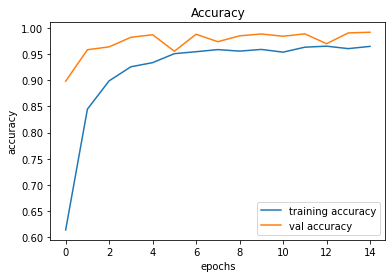

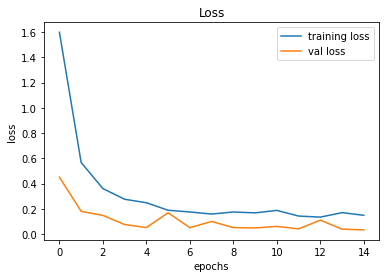

In [ ]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


### Fonction pour enregistrer le modele


In [ ]:
def save_classifier(model, basename):
  """Save to H5 format a TF model with a timestamp

  Paramaters
  ----------
  model: trained tf model
  basename: basename including path to use for filename

  Returns
  -------
  None
  """
  model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  return


In [ ]:
save_classifier(model, 'models/traffic_signs')

### Faire une prédiction avec le modèle

In [19]:
def classify_image(path, model, image_box=None):
  """Classify image by model

  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier

  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  images_list.append(image)
  
  return model.predict_classes(np.array(images_list))


In [21]:
image_sample = images_df.sample(1)

In [ ]:


classify_image(image_sample['path'].values[0],
               model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([13])

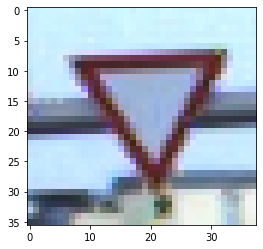

In [ ]:
plt.imshow(Image.open(image_sample['path'].values[0]))

### Reloading model

In [17]:
#Plus pour Jupyter seulement
test_model = load_model('../models/traffic_signs_2021-03-19_13-51-00.h5')

In [22]:
classify_image(image_sample['path'].values[0],
               test_model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([8], dtype=int64)

## Evaluation de performance avec le Final test set 

### Prédiction avec le modèle 

In [ ]:
%%time
results = test_model.predict_classes(test_data)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 377 ms, sys: 95.5 ms, total: 473 ms
Wall time: 1.65 s


In [ ]:
test_labels[:3]

array([16,  1, 38])

In [ ]:
test_labels == results

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
(test_labels == results).sum() / test_labels.shape[0]

0.966904196357878

### Comparaison avec la vraie valeur et la prédite 

In [ ]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

In [ ]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


In [ ]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index')

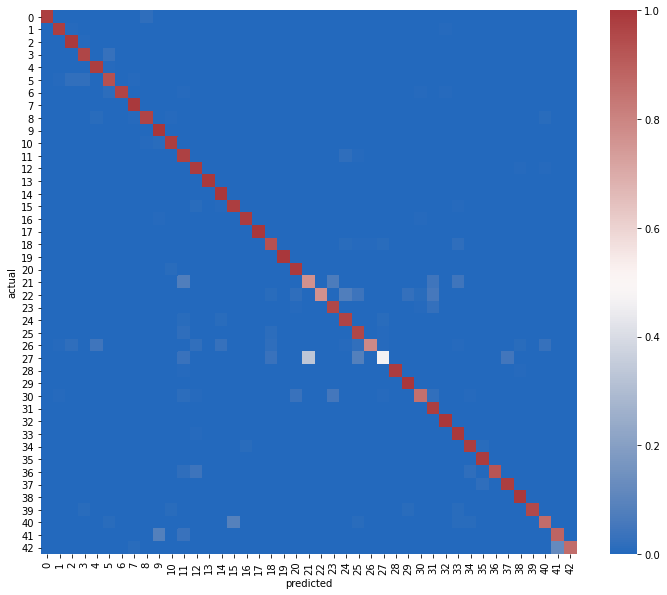

In [ ]:

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);

In [ ]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'])

# 2) SVM

## 2.1. Avec modèle par défaut sur tout l'échantillon 

### Création test train sets

In [14]:
N = 6000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [15]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [16]:
#Contrairement à avant, nous devons avoir une image flattened ce que nous allons faire :

size_train = X_train.shape[0]
size_test =  X_test.shape[0] 

#reshape les images pour qu'elles soient en 2700 plutôt que 30*30*3

X_train = X_train.reshape(size_train, -1)
X_test = X_test.reshape(size_test, -1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 2700) (7842, 2700) (31367,) (7842,)


In [17]:
np.unique(y_train) 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

### Création et entrainement du modèle svm

In [ ]:
svc_classifier = SVC(random_state= SEED) 
model = svc_classifier.fit(X_train, y_train) 

In [ ]:
print("the accuracy is :", accuracy_score(y_test, model.predict(X_test)))

the accuracy is : 0.9219586840091814


### Faire une prédiction avec ce modèle SVM sur images_df

In [ ]:
def classify_image(path, model, image_box=None):
  """Classify image by model

  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier

  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  images_list.append(image)
  
  return model.predict(np.array(images_list).reshape(1, -1))


In [ ]:
image_sample = images_df.sample(1)

classify_image(image_sample['path'].values[0],
               model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

array([10])

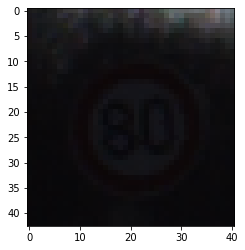

In [ ]:
plt.imshow(Image.open(image_sample['path'].values[0]))

### Evaluation de performance avec les données de "Final Test" 

In [56]:
#Sur ces données aussi nous devons reshape pour le SVM

size_testdata = test_data.shape[0] 

#reshape les images pour qu'elles soient en 2700 plutôt que 30*30*3

test_data = test_data.reshape(size_testdata, -1)



In [57]:
print(test_data.shape, test_labels.shape)

(12630, 2700) (12630,)


Prédiction avec le modèle

In [ ]:
%%time
results = model.predict(np.array(test_data))


CPU times: user 20min 7s, sys: 768 ms, total: 20min 8s
Wall time: 20min 10s


In [ ]:
results.shape

(12630,)

In [ ]:
results

array([16,  1, 38, ...,  5,  7, 10])

In [ ]:
test_labels[:3]

array([16,  1, 38])

In [ ]:
test_labels == results

array([ True,  True,  True, ..., False,  True,  True])

In [ ]:
(test_labels == results).sum() / test_labels.shape[0]

0.8050673000791766

In [33]:
#Avec les données final test l'accuracy du modèle par défaut baisse

Comparaison avec la vraie valeur et la prédite:

In [ ]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

In [ ]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


In [ ]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index')

predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.300000,0.533333,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.897222,0.059722,0.000000,0.019444,0.009722,0.000000,0.000000,0.008333,0.000000,0.000000,0.000000,0.001389,0.001389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.046667,0.805333,0.026667,0.025333,0.094667,0.000000,0.000000,0.000000,0.001333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.022222,0.000000,0.648889,0.000000,0.302222,0.000000,0.000000,0.008889,0.000000,0.011111,0.002222,0.000000,0.002222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.010606,0.118182,0.024242,0.027273,0.736364,0.031818,0.000000,0.000000,0.040909,0.000000,0.004545,0.001515,0.001515,0.001515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.020635,0.100000,0.003175,0.014286,0.823810,0.000000,0.001587,0.019048,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.013333,0.000000,0.113333,0.620000,0.000000,0.086667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.006667,0.000000,0.080000
7,0.000000,0.002222,0.013333,0.046667,0.026667,0.091111,0.000000,0.635556,0.157778,0.011111,0.011111,0.002222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.006667,0.015556,0.002222,0.004444,0.055556,0.000000,0.040000,0.851111,0.002222,0.000000,0.000000,0.002222,0.002222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002222,0.000000,0.000000,0.000000,0.000000,0.008889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.006667,0.000000,0.000000,0.000000,0.000000


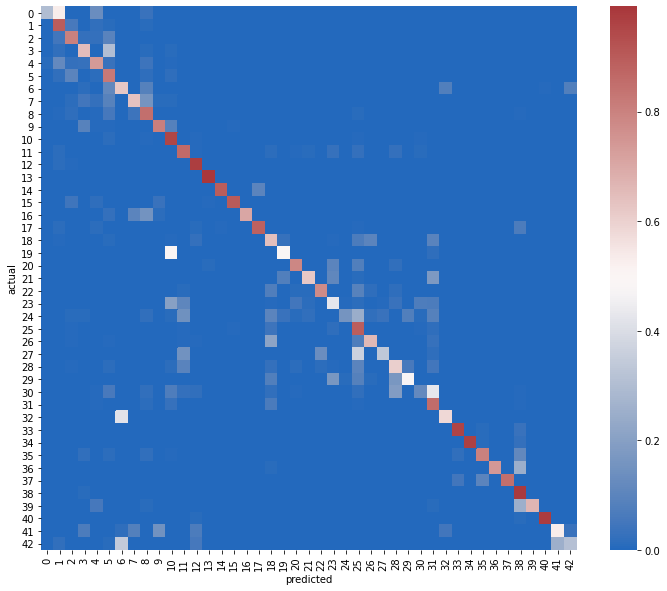

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);

*   Comparé au modèle de neural networs le SVM par défaut est bcp moins performant et prédit mal beaucoup de panneaux.
*   C'est pourquoi nous allons paramètrer un peu mieux le modèle en faisant seulement quelques test de paramètres puisque le temps d'execusion est très long

## 2.2. Modèle avec selection de paramètres 

### a)Tunning 



1.   Tests avec fonction sigmoid



In [12]:
c_para = [0.1, 1, 10]
#gamma_para = [1, 0.1, 0.01, 0.001]
kernel = ['sigmoid']

parameters_s1 = [c_para, kernel ]
parameters_s1 = list(itertools.product(*parameters_s1))
print( "all possible combinaisons of parameters : ", parameters_s1)

all possible combinaisons of parameters :  [(0.1, 'sigmoid'), (1, 'sigmoid'), (10, 'sigmoid')]


In [18]:
accuracy_scores = []
for i in range(len(parameters_s1)):
    svclassifier = SVC(C= parameters_s1[i][0] , kernel= parameters_s1[i][1], random_state=SEED )
    svclassifier.fit(X_train, y_train)
    pred = svclassifier.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, pred))
      
    print(i, ' done')

0  done
1  done
2  done


In [19]:
print(parameters_s1[accuracy_scores.index(max(accuracy_scores))])
print(max(accuracy_scores))

(1, 'sigmoid')
0.029074215761285386


Mauvais paramètres ici



2.   Tests avec fonction polynomiale



In [ ]:
c_para = [0.1, 1, 10]
#gamma_para = [1, 0.1, 0.01, 0.001]
kernel = ['poly']

parameters_s1 = [c_para, kernel ]
parameters_s1 = list(itertools.product(*parameters_s1))
print( "all possible combinaisons of parameters : ", parameters_s1)

all possible combinaisons of parameters :  [(0.1, 'poly'), (1, 'poly'), (10, 'poly')]


In [ ]:
accuracy_scores = []
for i in range(len(parameters_s1)):
    svclassifier = SVC(C= parameters_s1[i][0] , kernel= parameters_s1[i][1], random_state=SEED )
    svclassifier.fit(X_train, y_train)
    pred = svclassifier.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, pred))
      
    print(i, ' done')

0  done
1  done
2  done


In [ ]:
print(parameters_s1[accuracy_scores.index(max(accuracy_scores))])
print(max(accuracy_scores))

(10, 'poly')
0.8459576638612599


Déjà meilleur que le modèle d'avant 




3. Tests avec fonction linéaire



In [ ]:
c_para = [0.1, 1, 10]
#gamma_para = [1, 0.1, 0.01, 0.001]
kernel = [ 'linear']

parameters_s1 = [c_para, kernel ]
parameters_s1 = list(itertools.product(*parameters_s1))
print( "all possible combinaisons of parameters : ", parameters_s1)

all possible combinaisons of parameters :  [(0.1, 'linear'), (1, 'linear'), (10, 'linear')]


In [ ]:
accuracy_scores = []
for i in range(len(parameters_s1)):
    svclassifier = SVC(C= parameters_s1[i][0] , kernel= parameters_s1[i][1], random_state=SEED )
    svclassifier.fit(X_train, y_train)
    pred = svclassifier.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, pred))
      
    print(i, ' done')

0  done
1  done
2  done


In [ ]:
print(parameters_s1[accuracy_scores.index(max(accuracy_scores))])
print(max(accuracy_scores))

(0.1, 'linear')
0.9720734506503443


Nettement mieux que le modèle precedent 



4.  Tests avec fonction rbf



In [ ]:
c_para = [0.1, 1, 10]
#gamma_para = [1, 0.1, 0.01, 0.001]
kernel = [ 'rbf']

parameters_s1 = [c_para, kernel ]
parameters_s1 = list(itertools.product(*parameters_s1))
print( "all possible combinaisons of parameters : ", parameters_s1)

all possible combinaisons of parameters :  [(0.1, 'rbf'), (1, 'rbf'), (10, 'rbf')]


In [ ]:
accuracy_scores = []
for i in range(len(parameters_s1)):
    svclassifier = SVC(C= parameters_s1[i][0] , kernel= parameters_s1[i][1], random_state=SEED )
    svclassifier.fit(X_train, y_train)
    pred = svclassifier.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, pred))
      
    print(i, ' done')

0  done
1  done
2  done


In [ ]:
print(parameters_s1[accuracy_scores.index(max(accuracy_scores))])
print(max(accuracy_scores))

(10, 'rbf')
0.9812547819433818


Cette paramètrisation est donc la meilleure et nous garderons celle-ci. 

### b) Modèle final SVM

#### Création test et train 

In [24]:
N = 6000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [25]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [26]:
#Contrairement à avant, nous devons avoir une image flattened ce que nous allons faire :

size_train = X_train.shape[0]
size_test =  X_test.shape[0] 

#reshape les images pour qu'elles soient en 2700 plutôt que 30*30*3

X_train = X_train.reshape(size_train, -1)
X_test = X_test.reshape(size_test, -1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 2700) (7842, 2700) (31367,) (7842,)


In [27]:
np.unique(y_train) 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

#### Création et entrainement du modèle final

In [28]:
svc_classifier = SVC(C=10, kernel= 'rbf' , random_state=SEED) 
model = svc_classifier.fit(X_train, y_train) 

In [29]:
print("the accuracy is :", accuracy_score(y_test, model.predict(X_test)))

the accuracy is : 0.9793420045906657


#### Prédiction du modèle final sur la base initiale

In [19]:
def classify_image(path, model, image_box=None):
  """Classify image by model

  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier

  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  images_list.append(image)
  
  return model.predict(np.array(images_list).reshape(1, -1))


In [20]:
image_sample = images_df.sample(1)

classify_image(image_sample['path'].values[0],
               model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

array([4])

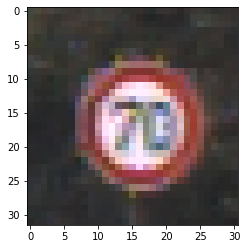

In [21]:
plt.imshow(Image.open(image_sample['path'].values[0]))

#### Exportation du modèle  

In [33]:
filename = '../models/traffic_signs_svm_final.h5'
pickle.dump(model, open(filename, 'wb'))

#### Reload le modele 

In [38]:
filename = '../models/traffic_signs_svm_final.h5'
model = pickle.load(open(filename, 'rb'))

#### Evaluation de pérformance avec les données de "Final Test"

evaluation de performance 

In [58]:
print(test_data.shape, test_labels.shape)

(12630, 2700) (12630,)


In [59]:
%%time
results = model.predict(np.array(test_data))


Wall time: 14min


In [60]:
results.shape

(12630,)

In [61]:
results

array([16,  1, 38, ...,  5,  7, 10], dtype=int64)

In [62]:
test_labels[:3]

array([16,  1, 38], dtype=int64)

In [63]:
test_labels == results

array([ True,  True,  True, ..., False,  True,  True])

In [64]:
(test_labels == results).sum() / test_labels.shape[0]

0.8528899445764054

Compare actual to predicted (class-level)

In [65]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

In [66]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


In [67]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'])

predicted,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
actual,,,,,,,,,,,,,,,,,,,,,
0,20,33,0,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,671,23,0,12,6,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
2,0,27,679,16,13,13,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,5,1,384,3,45,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,76,11,15,513,17,0,3,17,0,...,0,0,0,0,0,0,0,0,0,0
5,0,11,65,5,3,530,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,3,0,16,93,0,1,0,...,0,0,0,0,0,1,0,0,2,27
7,0,1,8,8,4,31,0,354,36,6,...,0,0,0,0,0,0,0,0,0,0
8,0,3,5,1,6,12,0,18,396,1,...,0,0,0,0,0,2,0,0,0,0


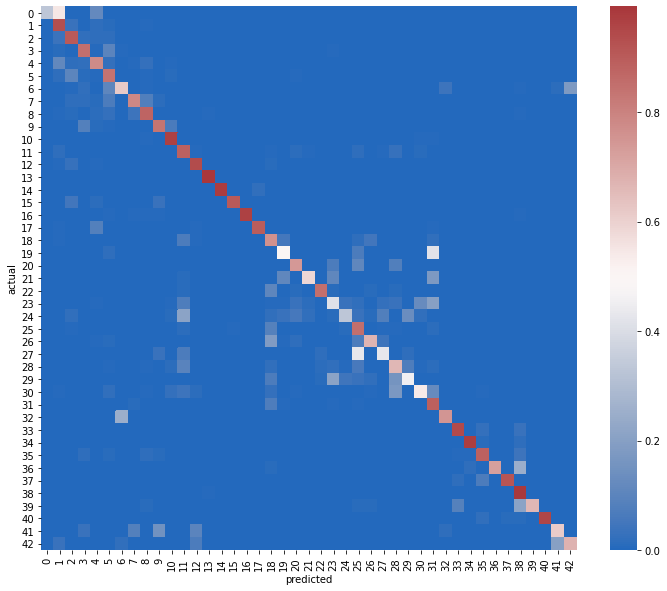

In [68]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);

# Comparaison des modèles 

- Si nous comparons les deux modèles ( Neural Network Vs SVM) on remarque que l'accuracy du modèle SVM est de 0,98 sur le train set mais lorsque l'on prédit avec les données de Final test, l'accuracy tombe à 0,85. Tandis que celle du NN est de 0,96 envrion. Le NN prédit donc mieux que le SVM, et ce, même après un leger tunning des paramètres.
- On peut voir que le modèle NN est plus fort grace à la figure croisant les valeurs prédites et les valeurs réelles. Celui du NN a beaucoup moins de zones blanches que celle du SVM. En effet, ces zone blanches sont en réalité un nombre assez important de panneaux qui ont été mal prédits. 
- Avec SVM bcp de 19 prédit en 31, ou 23 prédits en 31. Le SVM classe bcp de pannaux en 31. La classe 18 est également un problème car bcp de panneaux sont classés en 18 alors qui ne le sont pas.  
-Pour le NN il y a bcp moins de fautes de prédiction: on remarque principalement que certains des panneaux de la classe 27 sont classés en 21. Les reste est sont des erreurs de classification assez faibles. 
